<a href="https://colab.research.google.com/github/anjaleeDS/DataVizStanford/blob/master/DoordashPredictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

every nth line of excel

`=OFFSET(Sheet1!$A$1,(ROW()-1)*3,0)`

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
import altair as alt
import datetime as dt
import numpy as np

from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My\ Drive/
%cd Colab\ Notebooks
%cd Doordash\ Predictions


pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks
/gdrive/My Drive/Colab Notebooks/Doordash Predictions
display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


#Get data/ See data

In [0]:
spent_df = pd.read_csv('CCActivity20182020.csv') #from march 2018-current
orders_df = pd.read_csv('DoorDashHistoryCSV.csv', header=None) #from jun 2018-current, set header to none
# orders_df

In [0]:
o_df = pd.DataFrame({'restaurant':orders_df[0].iloc[::3].values,
                     'datebill':orders_df[0].iloc[1::3].values,
                    'items':orders_df[0].iloc[2::3].values})
o_df.head(5)

,restaurant,datebill,items
0,New York Pizza,"Delivered: May 17th 2020, 3:25pm • $43.14","Cheese Bread (8 Pieces), 2L Diet Coca cola, Cheese Pizza (Large)"
1,Wingstop,"Delivered: May 15th 2020, 7:19pm • $37.67","Soft Drinks, Triple Chocolate Chunk Brownie, 25pc Boneless Family Bundle"
2,Ocha Tea Café & Restaurant,Order for Pickup: Ready by 3:47 pm • $43.85,"Mango Flavored Tea, Fresh Taro Grass Jelly Milk, Hot Black Sugar Milk Tea, Fried Pork Chop, Crispy Chicken"
3,Los Altos Taqueria,"Delivered: May 8th 2020, 7:52pm • $36.33","43. Los Altos Mar Y Tierra, Natural Fruit Drink (20 oz.), 1. Super Burrito Wet"
4,Doppio Zero,"Delivered: May 7th 2020, 7:36pm • $54.02","Trecciolina, La Carne, Margherita"


In [0]:
o_df['bill'] = o_df['datebill'].str.extract('(\d\d\.\d\d)', expand=True)
o_df['bill'] = o_df['bill'].astype('float')

o_df['date'] = o_df['datebill'].str.extract('(\w\w\w\s\d*\w\w\s\d*\,\s\d*:\d\d\w\w)', expand=True)
o_df['date'] = pd.to_datetime(o_df['date'])
# o_df['dt'] = o_df['dt'].fillna(0)

o_df['items'] = o_df['items'].str.split(pat=r",\ ", expand=False)
o_df.head(5)

,restaurant,datebill,items,bill,date
0,New York Pizza,"Delivered: May 17th 2020, 3:25pm • $43.14","[Cheese Bread (8 Pieces), 2L Diet Coca cola, Cheese Pizza (Large)]",43.14,2020-05-17 15:25:00
1,Wingstop,"Delivered: May 15th 2020, 7:19pm • $37.67","[Soft Drinks, Triple Chocolate Chunk Brownie, 25pc Boneless Family Bundle]",37.67,2020-05-15 19:19:00
2,Ocha Tea Café & Restaurant,Order for Pickup: Ready by 3:47 pm • $43.85,"[Mango Flavored Tea, Fresh Taro Grass Jelly Milk, Hot Black Sugar Milk Tea, Fried Pork Chop, Crispy Chicken]",43.85,NaT
3,Los Altos Taqueria,"Delivered: May 8th 2020, 7:52pm • $36.33","[43. Los Altos Mar Y Tierra, Natural Fruit Drink (20 oz.), 1. Super Burrito Wet]",36.33,2020-05-08 19:52:00
4,Doppio Zero,"Delivered: May 7th 2020, 7:36pm • $54.02","[Trecciolina, La Carne, Margherita]",54.02,2020-05-07 19:36:00


In [0]:
o_df['hr'] = o_df['date'].dt.hour
o_df['dow'] = o_df['date'].dt.dayofweek
o_df['dow'].unique()

array([ 6.,  4., nan,  3.,  2.,  0.,  1.,  5.])

In [0]:
o_df.dtypes
o_df.bfill(axis='rows') # fill the NaNs


,restaurant,datebill,items,bill,date,hr,dow
0,New York Pizza,"Delivered: May 17th 2020, 3:25pm • $43.14","[Cheese Bread (8 Pieces), 2L Diet Coca cola, Cheese Pizza (Large)]",43.14,2020-05-17 15:25:00,15.0,6.0
1,Wingstop,"Delivered: May 15th 2020, 7:19pm • $37.67","[Soft Drinks, Triple Chocolate Chunk Brownie, 25pc Boneless Family Bundle]",37.67,2020-05-15 19:19:00,19.0,4.0
2,Ocha Tea Café & Restaurant,Order for Pickup: Ready by 3:47 pm • $43.85,"[Mango Flavored Tea, Fresh Taro Grass Jelly Milk, Hot Black Sugar Milk Tea, Fried Pork Chop, Crispy Chicken]",43.85,2020-05-08 19:52:00,19.0,4.0
3,Los Altos Taqueria,"Delivered: May 8th 2020, 7:52pm • $36.33","[43. Los Altos Mar Y Tierra, Natural Fruit Drink (20 oz.), 1. Super Burrito Wet]",36.33,2020-05-08 19:52:00,19.0,4.0
4,Doppio Zero,"Delivered: May 7th 2020, 7:36pm • $54.02","[Trecciolina, La Carne, Margherita]",54.02,2020-05-07 19:36:00,19.0,3.0
5,Steam,"Delivered: May 6th 2020, 6:05pm • $60.76","[Crispy Shrimp Balls (3 Pc), HK Pan Fried Noodle with Beef/Chicken/Seafood, Sticky Rice in Lotus Leaf (2 Pc), Shanghai Pork Dumplings (4 Pc), Pork & Shrimp Shui Mai (4 Pc)]",60.76,2020-05-06 18:05:00,18.0,2.0
6,Shana Thai,"Delivered: May 1st 2020, 7:28pm • $75.26","[Papaya Salad, Pad See-Ew, Seafood Salad, Red Curry]",75.26,2020-05-01 19:28:00,19.0,4.0
7,Ocha Tea Café & Restaurant,"Delivered: Apr 29th 2020, 1:47pm • $42.90","[Matcha Milk Tea, Pork Stew Rice Noodle Soup, Thai Tea, Crispy Chicken]",42.90,2020-04-29 13:47:00,13.0,2.0
8,Starbird Chicken,"Delivered: Apr 27th 2020, 7:56pm • $0.00","[House Fries, Starbird®, Chicken Chop]",34.08,2020-04-27 19:56:00,19.0,0.0
9,L&L Hawaiian Barbecue,"Delivered: Apr 20th 2020, 11:53am • $34.08","[7. Fried Shrimp, Hawaiian Sun, Healthy Garlic Basa, 16. Chicken Katsu]",34.08,2020-04-20 11:53:00,11.0,0.0


In [0]:
#  === WHERE DID I ORDER THE MOST (ALTAIR ed) #######################################

alt.Chart(o_df).mark_bar().encode(
    alt.Y('restaurant:N', sort="-x", axis=alt.Axis(title='Restaurants')),
    alt.X('count(restaurant):Q', axis=alt.Axis(title='# of Times Ordered', orient='top')),
    color='year(date)',
    tooltip=('sum(bill)')
).interactive() 

alt.Chart(...)

In [0]:

#### ==== behavior per month? #####

alt.Chart(o_df).mark_bar().encode(
    x = alt.X('month(date)',axis=alt.Axis(title='Month (years are collapsed)')),
    y = alt.Y('bill',axis=alt.Axis(title='$$$')),
    shape='year(date):O',
    color='year(date):O',
    tooltip=('restaurant','mean(bill)','date','items')
).transform_bin(
    'binned_count', field='date'
).interactive()


alt.Chart(...)

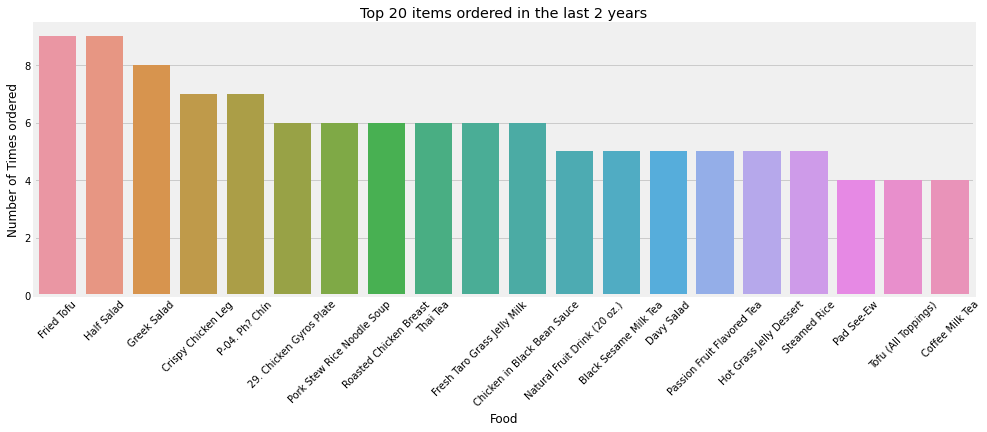

In [0]:
# =====WHAT DID I ORDER THE MOST (SNS ed) #######################################
food_items =+ o_df['items']

####################################
# OMG THIS LAMBDA FUNCTION IS BOMB #
####################################
food_list = [item for sublist in food_items for item in sublist]

(unique, counts) = np.unique(food_list, return_counts=True)
frequencies = pd.DataFrame(np.asarray((unique, counts)).T)
f_sorted = frequencies.sort_values(by=[1], ascending=False)

for_bar = f_sorted.head(20)

plt.figure(figsize=(15,5))
barchart = sns.barplot(data=for_bar, 
            x=0, y=1,)
barchart.set_xticklabels(barchart.get_xticklabels(),rotation=45)
barchart.set(xlabel='Food', ylabel='Number of Times ordered', title="Top 20 items ordered in the last 2 years")
plt.show()

## Boring. need to break up words into nouns and preparation

In [0]:
plt.figure(figsize=(15,5))

base = alt.Chart(o_df).mark_circle(opacity=0.5).transform_fold(
    fold=['0', '1', '2', '3', '4','5','6'],
    as_=['whatever', 'wahtever']
).encode(
    alt.X('month(date):O'),
    alt.Y('mean(bill):Q'),
    alt.Color('dow:N'),
    tooltip=('restaurant','mean(bill)','date','items')

)

base + base.transform_loess('date', 'bill', groupby=['dow']).mark_line(size=4)


alt.LayerChart(...)

<Figure size 1080x360 with 0 Axes>

In [0]:
spent_df
spent_df.columns

Index(['Transaction Date', 'Post Date', 'Description', 'Category', 'Type',
       'Amount'],
      dtype='object')

In [0]:
### ==== but the 9.99 cost to get free shipping is in the way

line = alt.Chart(spent_df).mark_line(
    color='red',
    size=3
).transform_window(
    rolling_mean='mean(Amount)',
    frame=[-15, 15]
).encode(
    x='Transaction Date:T',
    y='rolling_mean:Q'
)

points = alt.Chart(spent_df).mark_point().encode(
    x='Transaction Date:T',
    y=alt.Y('Amount:Q',
            axis=alt.Axis(title='$$$'), scale=alt.Scale(domain=[0,-90]))
)

points + line
### ==== get rid of them!

alt.LayerChart(...)

In [0]:
no_fee_df = spent_df.loc[spent_df['Description']!= "DOORDASH DASHPASS"]
line = alt.Chart(no_fee_df).mark_line(
    color='red',
    size=3
).transform_window(
    rolling_mean='mean(Amount)',
    frame=[-15, 15]
).encode(
    x='Transaction Date:T',
    y='rolling_mean:Q'
)

points = alt.Chart(no_fee_df).mark_circle().encode(
    x='Transaction Date:T',
    y=alt.Y('Amount:Q',
            axis=alt.Axis(title='$$$'), 
            scale=alt.Scale(domain=[0,-90]))
)

points + line

alt.LayerChart(...)

#Prediction stuff

1. what's the spend like every month?
2. what's the likelihood that i'll order particular restaurant on a particular day?



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



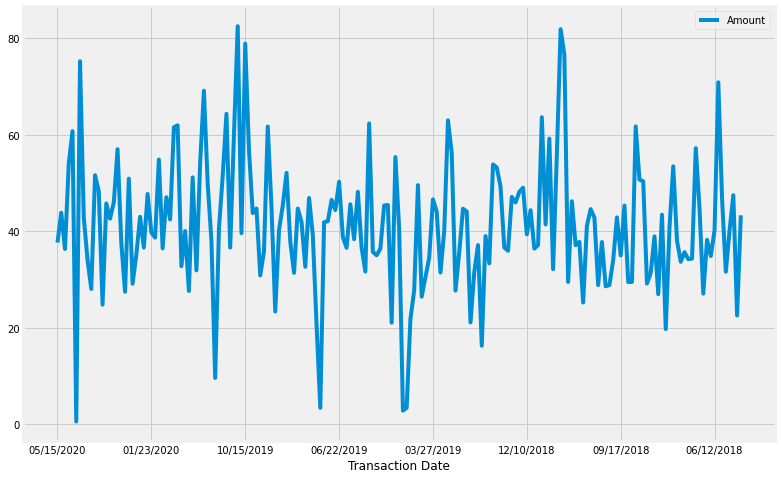

In [0]:
# change bill to positive numbers
pdf = no_fee_df[['Transaction Date','Amount']]
pdf['Amount'] = abs(pdf['Amount'])
pdf.set_index('Transaction Date').plot(figsize=(12, 8))
plt.show()

In [0]:
pdf.rename(columns={'Transaction Date': 'ds', 'Amount': 'y'},inplace=True)
# pdf.reset_index(drop=True, inplace=True)
pdf.head(3)
# pdf.set_index('0', drop=True)

In [0]:
pdf.rename(columns={'DS': 'ds', 'Amount': 'y'},inplace=True)
pdf

In [0]:
my_model = Prophet(interval_width=0.95)
my_model.fit(pdf)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future_dates =  my_model.make_future_dataframe(periods=18, freq='MS')
future_dates.tail()

,ds
196,2021-07-01
197,2021-08-01
198,2021-09-01
199,2021-10-01
200,2021-11-01


In [0]:
forecast =  my_model.predict(future_dates)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
196,2021-07-01,45.912783,16.629636,71.074235,45.912775,45.912792,-2.397077,-2.397077,-2.397077,-2.397077,-2.397077,-2.397077,0.0,0.0,0.0,43.515706
197,2021-08-01,46.102525,22.710896,73.145995,46.102516,46.102535,1.415368,1.415368,1.415368,1.415368,1.415368,1.415368,0.0,0.0,0.0,47.517894
198,2021-09-01,46.292268,22.893922,73.086053,46.292258,46.292278,1.337639,1.337639,1.337639,1.337639,1.337639,1.337639,0.0,0.0,0.0,47.629906
199,2021-10-01,46.475889,19.031048,70.376589,46.475878,46.475900,-1.956897,-1.956897,-1.956897,-1.956897,-1.956897,-1.956897,0.0,0.0,0.0,44.518992
200,2021-11-01,46.665631,19.619139,71.706289,46.665620,46.665644,-1.010694,-1.010694,-1.010694,-1.010694,-1.010694,-1.010694,0.0,0.0,0.0,45.654938


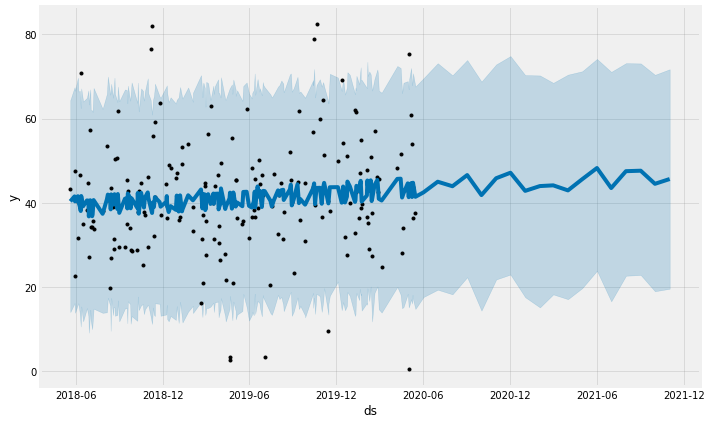

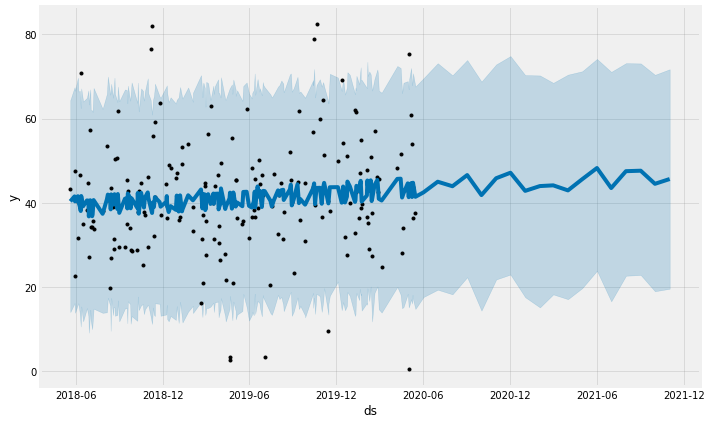

In [0]:
my_model.plot(forecast, uncertainty=True)

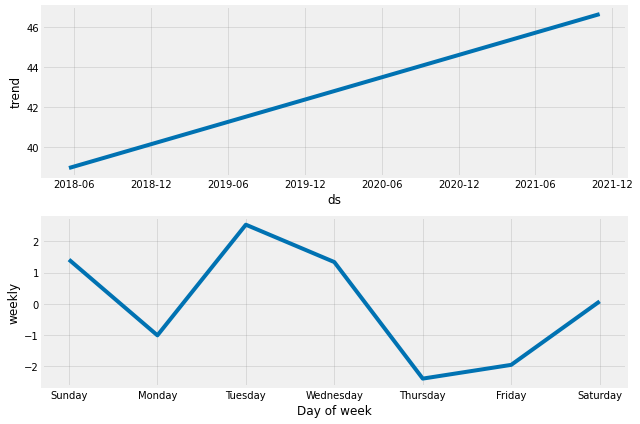

In [0]:
fig2 = my_model.plot_components(forecast)


*month_bill_data*

```
ds	y
0	2018-06	374.50
1	2018-07	233.20
2	2018-08	435.42
3	2018-09	244.20
4	2018-10	324.88
5	2018-11	448.03
6	2018-12	310.50
7	2019-01	228.98
8	2019-02	267.17
9	2019-03	409.84
10	2019-04	242.48
11	2019-05	322.56
12	2019-06	469.28
13	2019-07	100.12
14	2019-08	293.58
15	2019-09	241.41
16	2019-10	441.61
17	2019-11	232.07
18	2019-12	324.14
19	2020-01	415.68
20	2020-02	499.03
21	2020-03	24.79
22	2020-04	204.97
23	2020-05	307.18
```



#MAPS STUFF

In [0]:
import folium
from folium import 